# SIF Analysis: Tariffs & Crop Shifts in the Corn Belt

This notebook analyzes Solar-Induced Chlorophyll Fluorescence (SIF) data from OCO-2/OCO-3 satellites to investigate how U.S. trade tariffs, input costs, and management changes since 2020 have influenced vegetation productivity across the U.S. Corn Belt.

**Dataset**: Harmonized, gap-filled global SIF product (2014-2024) by Jiaming Wen et al.

**Goals**:
- Visualize SIF changes over time (2014-2024) 
- Create US-focused animation showing temporal patterns
- Later: Overlay with USDA Cropland Data Layer for crop-specific analysis


In [2]:
# Test paths and verify we can find the data
from pathlib import Path
import os

print("Current working directory:", os.getcwd())
print()

# Test the data directory path
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
print(f"Looking for data in: {data_dir}")
print(f"Data directory exists: {data_dir.exists()}")
print(f"Absolute path: {data_dir.absolute()}")

if data_dir.exists():
    nc4_files = list(data_dir.glob("*.nc4"))
    print(f"Found {len(nc4_files)} .nc4 files")
    if nc4_files:
        print(f"First file: {nc4_files[0].name}")
        print("✓ Data directory and files found!")
    else:
        print("⚠ Data directory exists but no .nc4 files found")
else:
    print("❌ Data directory not found - check the path")

print()
print("If this works, you can proceed to run the other cells in order.")


Current working directory: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src

Looking for data in: ../data/raw/SIF_OCO2_005_v11r
Data directory exists: True
Absolute path: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src/../data/raw/SIF_OCO2_005_v11r
Found 251 .nc4 files
First file: sif_ann_201503a.nc4
✓ Data directory and files found!

If this works, you can proceed to run the other cells in order.


## 1. Setup and Data Discovery


In [3]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import imageio
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

ds = xr.open_dataset("../data/raw/SIF_OCO2_005_v11r/sif_ann_201409a.nc4")
print(ds.dims)
print(ds.coords)


FrozenMappingWarningOnValuesAccess({'latitude': 3600, 'longitude': 7200})
Coordinates:
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * latitude   (latitude) float64 29kB -89.97 -89.92 -89.88 ... 89.92 89.97


In [4]:
# Define paths
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
figures_dir = Path("../figures")

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Figures directory: {figures_dir}")


Data directory: ../data/raw/SIF_OCO2_005_v11r
Figures directory: ../figures


In [5]:
# List all .nc4 files and extract temporal information
nc4_files = sorted(data_dir.glob("*.nc4"))
print(f"Found {len(nc4_files)} .nc4 files")

# Extract detailed information from filenames
# Format: sif_ann_yyyymm"a"or"b".nc4 (e.g., sif_ann_201401a.nc4, sif_ann_201401b.nc4)

file_info = []
for file in nc4_files:
    filename = file.name
    if 'sif_ann_' in filename:
        # Extract the part after 'sif_ann_' and before '.nc4'
        year_month_part = filename.split('sif_ann_')[1].split('.nc4')[0]
        
        if year_month_part.endswith('a') or year_month_part.endswith('b'):
            # Extract all components
            half = year_month_part[-1]  # 'a' = first half, 'b' = second half of month
            year_month = year_month_part[:-1]  # Remove 'a' or 'b'
            year = year_month[:4]  # Extract year (e.g., '2014')
            month = year_month[4:]  # Extract month (e.g., '01')
            
            # Store detailed info
            file_info.append({
                'filename': filename,
                'year': year,
                'month': month,
                'half': half,
                'half_description': 'first half' if half == 'a' else 'second half',
                'year_month': year_month,
                'file_path': file,
                'sort_key': f"{year}{month}{half}"  # For proper chronological sorting
            })

# Sort by chronological order
file_info = sorted(file_info, key=lambda x: x['sort_key'])

# Create summary
years = sorted(list(set([info['year'] for info in file_info])))
months = sorted(list(set([info['month'] for info in file_info])))

print(f"\n📊 Dataset Summary:")
print(f"  Total files: {len(file_info)}")
print(f"  Years: {years} ({len(years)} years)")
print(f"  Months: {months} ({len(months)} months)")
print(f"  Year range: {min(years)} - {max(years)}")

# Show first few files in chronological order
print(f"\n📁 First 5 files (chronological order):")
for i, info in enumerate(file_info[:5]):
    print(f"  {info['filename']} → {info['year']}-{info['month']} ({info['half_description']})")


Found 251 .nc4 files

📊 Dataset Summary:
  Total files: 251
  Years: ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025'] (12 years)
  Months: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] (12 months)
  Year range: 2014 - 2025

📁 First 5 files (chronological order):
  sif_ann_201409a.nc4 → 2014-09 (first half)
  sif_ann_201409b.nc4 → 2014-09 (second half)
  sif_ann_201410a.nc4 → 2014-10 (first half)
  sif_ann_201410b.nc4 → 2014-10 (second half)
  sif_ann_201411a.nc4 → 2014-11 (first half)


## 2. Monthly Averages
Take monthly averages only in Iowa of SIF. Calculate morning (a) and evening (b). As well as the combined avergae.

#### i. Set up

In [6]:
# Create agricultural masks for each year (2014-2024)
ag_masks = {}
for year in range(2014, 2025):
    cdl_path = f'/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/Cornbelt_annual_CDL/Cornbelt_annual_CDL_cropland_{year}-01.tif'
    cdl_data = rioxarray.open_rasterio(cdl_path, masked=True)
    
    # Create mask for agricultural land (corn=1, soy=5)
    ag_mask_year = xr.where((cdl_data == 1) | (cdl_data == 5), 1, 0)
    ag_masks[year] = ag_mask_year
    
print(f"Created agricultural masks for years {list(ag_masks.keys())}")


Created agricultural masks for years [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [7]:
# Load libraries
from pathlib import Path
import re, numpy as np, pandas as pd, xarray as xr

# Create path to SIF data
SIF_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/SIF_OCO2_005_v11r")

# Clip by a simple Iowa bounding box (EPSG:4326) to speed things up
USE_BBOX = True  # set False if you prefer loading a shapefile/poly later
IOWA_BBOX = (-96.639, -90.140, 40.375, 43.501)  # lon_min, lon_max, lat_min, lat_max

# Where to save quick CSV outputs 
OUT_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


#### ii. Load in CDL Data

In [8]:
# Load CDL rasters for 2014-2024 and check CRS compatibility
import rasterio

# Define CDL directory
CDL_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/Cornbelt_annual_CDL")

# Find all CDL files
CDL_FILES = list(CDL_DIR.glob("*.tif"))
print(f"Found {len(CDL_FILES)} CDL files")

# Filter for years 2014-2024 and create a dictionary
cdl_files_by_year = {}
for file in CDL_FILES:
    # Extract year from filename (e.g., "Cornbelt_annual_CDL_cropland_2010-01.tif" -> "2010")
    year = int(file.stem.split('_')[-1].split('-')[0])
    if 2014 <= year <= 2024:
        cdl_files_by_year[year] = file
        print(f"  - {file.name} (Year: {year})")

print(f"\nCDL files for 2014-2024: {len(cdl_files_by_year)} files")
print(f"Years available: {sorted(cdl_files_by_year.keys())}")

# Check CDL file properties
print(f"\nChecking CDL file properties...")

# Load a sample CDL file to check its properties
sample_cdl_file = list(cdl_files_by_year.values())[0]
print(f"Sample CDL file: {sample_cdl_file.name}")

with rasterio.open(sample_cdl_file) as cdl_ds:
    cdl_crs = cdl_ds.crs
    print(f"CDL CRS: {cdl_crs}")
    
    # Show other properties
    print(f"CDL shape: {cdl_ds.shape}")
    print(f"CDL bounds: {cdl_ds.bounds}")
    print(f"CDL bands: {cdl_ds.count}")
    print(f"Band names: {cdl_ds.descriptions}")

print("✓ CDL loading complete!")
print("Note: CRS compatibility with SIF data will be checked later when file_info is available.")


Found 15 CDL files
  - Cornbelt_annual_CDL_cropland_2022-01.tif (Year: 2022)
  - Cornbelt_annual_CDL_cropland_2018-01.tif (Year: 2018)
  - Cornbelt_annual_CDL_cropland_2014-01.tif (Year: 2014)
  - Cornbelt_annual_CDL_cropland_2020-01.tif (Year: 2020)
  - Cornbelt_annual_CDL_cropland_2016-01.tif (Year: 2016)
  - Cornbelt_annual_CDL_cropland_2024-01.tif (Year: 2024)
  - Cornbelt_annual_CDL_cropland_2019-01.tif (Year: 2019)
  - Cornbelt_annual_CDL_cropland_2015-01.tif (Year: 2015)
  - Cornbelt_annual_CDL_cropland_2023-01.tif (Year: 2023)
  - Cornbelt_annual_CDL_cropland_2017-01.tif (Year: 2017)
  - Cornbelt_annual_CDL_cropland_2021-01.tif (Year: 2021)

CDL files for 2014-2024: 11 files
Years available: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Checking CDL file properties...
Sample CDL file: Cornbelt_annual_CDL_cropland_2022-01.tif
CDL CRS: EPSG:4326
CDL shape: (697, 1448)
CDL bounds: BoundingBox(left=-96.64075826557813, bottom=40.3747804447519, right=-90.1369556

#### iii. Resize the CDL to match SIF

In [11]:
# FAST downscale CDL data using block-based mode resampling
from scipy.stats import mode
import numpy as np

def downscale_cdl_mode_fast(cdl_array, target_shape):
    """
    Fast downscale of CDL data using block-based mode resampling for categorical data.
    This is MUCH faster than generic_filter approach.
    
    Parameters:
    -----------
    cdl_array : numpy.ndarray
        Input CDL array to downscale (2D)
    target_shape : tuple
        Target (height, width) for the output array
    
    Returns:
    --------
    numpy.ndarray
        Downscaled CDL array using mode resampling
    """
    input_height, input_width = cdl_array.shape
    target_height, target_width = target_shape
    
    # Calculate block sizes
    block_height = input_height // target_height
    block_width = input_width // target_width
    
    # Trim the array to be evenly divisible by blocks
    trimmed_height = target_height * block_height
    trimmed_width = target_width * block_width
    cdl_trimmed = cdl_array[:trimmed_height, :trimmed_width]
    
    # Reshape into blocks and compute mode
    # Reshape to (target_height, block_height, target_width, block_width)
    blocks = cdl_trimmed.reshape(
        target_height, block_height,
        target_width, block_width
    )
    
    # Move block dimensions together: (target_height, target_width, block_height, block_width)
    blocks = blocks.transpose(0, 2, 1, 3)
    
    # Flatten the block dimensions: (target_height, target_width, block_height*block_width)
    blocks = blocks.reshape(target_height, target_width, -1)
    
    # Compute mode for each block (much faster than generic_filter!)
    downscaled = np.empty((target_height, target_width), dtype=cdl_array.dtype)
    
    for i in range(target_height):
        for j in range(target_width):
            block_values = blocks[i, j, :]
            # Remove NaN values if any
            valid_values = block_values[~np.isnan(block_values)] if block_values.dtype == float else block_values
            if len(valid_values) > 0:
                downscaled[i, j] = mode(valid_values, keepdims=False)[0]
            else:
                downscaled[i, j] = 0  # or np.nan
    
    return downscaled

# Alternative: EVEN FASTER version using numpy bincount (for integer data)
def downscale_cdl_mode_fastest(cdl_array, target_shape):
    """
    Fastest downscale using bincount for mode calculation.
    Only works with integer categorical data (which CDL is).
    
    Parameters:
    -----------
    cdl_array : numpy.ndarray
        Input CDL array to downscale (2D, integer dtype)
    target_shape : tuple
        Target (height, width) for the output array
    
    Returns:
    --------
    numpy.ndarray
        Downscaled CDL array using mode resampling
    """
    input_height, input_width = cdl_array.shape
    target_height, target_width = target_shape
    
    # Calculate block sizes
    block_height = input_height // target_height
    block_width = input_width // target_width
    
    # Trim the array to be evenly divisible by blocks
    trimmed_height = target_height * block_height
    trimmed_width = target_width * block_width
    cdl_trimmed = cdl_array[:trimmed_height, :trimmed_width].astype(int)
    
    # Reshape into blocks
    blocks = cdl_trimmed.reshape(
        target_height, block_height,
        target_width, block_width
    ).transpose(0, 2, 1, 3).reshape(target_height, target_width, -1)
    
    # Compute mode using bincount (fastest method for integers)
    downscaled = np.empty((target_height, target_width), dtype=cdl_array.dtype)
    
    for i in range(target_height):
        for j in range(target_width):
            block_values = blocks[i, j, :]
            
            # Filter out negative values (NoData/masked values)
            valid_values = block_values[block_values >= 0]
            
            if len(valid_values) > 0:
                # Use bincount to find mode (fastest for integers)
                counts = np.bincount(valid_values)
                downscaled[i, j] = np.argmax(counts)
            else:
                # If no valid values, set to 0 or a NoData value
                downscaled[i, j] = 0
    
    return downscaled

print("✓ Fast CDL downscaling functions loaded!")
print("  - downscale_cdl_mode_fast: Works with any data")
print("  - downscale_cdl_mode_fastest: Fastest for integer categorical data (recommended for CDL)")


✓ Fast CDL downscaling functions loaded!
  - downscale_cdl_mode_fast: Works with any data
  - downscale_cdl_mode_fastest: Fastest for integer categorical data (recommended for CDL)


#### iv. Clip CDL, Downscale and Identify Ag

In [ ]:
# Clip CDL data to Iowa and create agricultural masks
# Iowa bounding box (lon_min, lon_max, lat_min, lat_max)
IOWA_BBOX = (-96.639, -90.140, 40.375, 43.501)

# Target SIF shape for Iowa (from previous SIF analysis)
target_sif_shape = (62, 130)

# Dictionary to store agricultural masks for each year
ag_masks = {}
cdl_clipped = {}

print("Processing CDL data for years 2014-2024...\n")

for year in sorted(cdl_files_by_year.keys()):
    cdl_file = cdl_files_by_year[year]
    print(f"Processing year {year}...")
    
    # Step 1: Load CDL data using rioxarray
    cdl_data = rioxarray.open_rasterio(cdl_file, masked=True)
    print(f"  Original CDL shape: {cdl_data.shape}")
    
    # Step 2: Clip to Iowa bounding box
    # CDL uses geographic coordinates (lat/lon), so we can clip directly
    lon_min, lon_max, lat_min, lat_max = IOWA_BBOX
    
    # Clip using xarray selection
    cdl_iowa = cdl_data.sel(
        x=slice(lon_min, lon_max),
        y=slice(lat_max, lat_min)  # y often goes from high to low
    )
    print(f"  Iowa-clipped CDL shape: {cdl_iowa.shape}")
    
    # Step 3: Downscale to match SIF resolution using mode-based resampling
    # Extract the 2D array (first band)
    cdl_array = cdl_iowa.values[0, :, :]  # Remove band dimension
    
    # Downscale using the FAST mode-based function (uses bincount - much faster!)
    cdl_downscaled = downscale_cdl_mode_fastest(cdl_array, target_sif_shape)
    print(f"  Downscaled CDL shape: {cdl_downscaled.shape}")
    
    # Step 4: Create agricultural mask for ALL cropland
    # CDL codes: 1-61 are typical cropland, plus some tree crops up to ~250
    # Exclude non-ag: 0 (background), 63-65 (forest), 81-88 (developed/water/wetlands), 111+ (water, developed, forest, grass/pasture, wetlands)
    # See: https://www.nass.usda.gov/Research_and_Science/Cropland/docs/cdl_codes_names.csv
    
    # Create mask for all agricultural/cropland pixels
    # Include: 1-61 (all crops), 66-77 (orchards/tree crops), 204-254 (specific crops)
    # Exclude: 0 (background), 60 (fallow), 63-65 (forest), 81+ (non-ag)
    ag_mask = np.where(
        ((cdl_downscaled >= 1) & (cdl_downscaled <= 59)) |  # All crops (excluding fallow/idle at 61)
        ((cdl_downscaled >= 66) & (cdl_downscaled <= 77)) |  # Tree crops/orchards
        ((cdl_downscaled >= 204) & (cdl_downscaled <= 254)), # Other specific crops
        1, 0
    )
    
    # Report unique crop types found
    unique_crops = np.unique(cdl_downscaled[cdl_downscaled > 0])
    print(f"  Unique crop codes found: {unique_crops[:20]}...")  # Show first 20
    
    # Calculate statistics
    total_pixels = ag_mask.size
    ag_pixels = np.sum(ag_mask)
    ag_percentage = (ag_pixels / total_pixels) * 100
    
    print(f"  Agricultural pixels: {ag_pixels}/{total_pixels} ({ag_percentage:.1f}%)")
    
    # Store in dictionaries
    cdl_clipped[year] = cdl_downscaled
    ag_masks[year] = ag_mask
    print(f"  ✓ Year {year} complete\n")

print("="*60)
print(f"CDL processing complete!")
print(f"Years processed: {sorted(ag_masks.keys())}")
print(f"Final shape for each year: {target_sif_shape}")
print(f"Total ag masks created: {len(ag_masks)}")
print()
print("Agricultural mask includes ALL cropland:")
print("  - Field crops: corn, soy, wheat, oats, barley, etc.")
print("  - Specialty crops: vegetables, melons, etc.")
print("  - Hay and forage crops: alfalfa, other hay")
print("  - Tree crops: orchards, vineyards, etc.")
print("  - Excludes: forest, developed land, water, grassland/pasture, wetlands")
print("="*60)


Processing CDL data for years 2014-2024...

Processing year 2014...
  Original CDL shape: (1, 697, 1448)
  Iowa-clipped CDL shape: (1, 696, 1447)
  Downscaled CDL shape: (62, 130)
  Agricultural pixels: 5030/8060 (62.4%)
  ✓ Year 2014 complete

Processing year 2015...
  Original CDL shape: (1, 697, 1448)
  Iowa-clipped CDL shape: (1, 696, 1447)
  Downscaled CDL shape: (62, 130)
  Agricultural pixels: 4919/8060 (61.0%)
  ✓ Year 2015 complete

Processing year 2016...
  Original CDL shape: (1, 697, 1448)
  Iowa-clipped CDL shape: (1, 696, 1447)
  Downscaled CDL shape: (62, 130)
  Agricultural pixels: 4943/8060 (61.3%)
  ✓ Year 2016 complete

Processing year 2017...
  Original CDL shape: (1, 697, 1448)
  Iowa-clipped CDL shape: (1, 696, 1447)
  Downscaled CDL shape: (62, 130)
  Agricultural pixels: 5060/8060 (62.8%)
  ✓ Year 2017 complete

Processing year 2018...
  Original CDL shape: (1, 697, 1448)
  Iowa-clipped CDL shape: (1, 696, 1447)
  Downscaled CDL shape: (62, 130)
  Agricultural p

v. Prepare ag masks for use with SIF

In [ ]:
# The masks are already at the correct resolution (62, 130) matching Iowa SIF data

print("Agricultural Masks Ready for SIF Processing")
print("=" * 60)
print(f"Years with ag masks: {sorted(ag_masks.keys())}")
print(f"Mask shape: {list(ag_masks.values())[0].shape}")
print()

# Display statistics for each year
for year in sorted(ag_masks.keys()):
    mask = ag_masks[year]
    total = mask.size
    ag_pixels = np.sum(mask)
    ag_pct = (ag_pixels / total) * 100
    print(f"  {year}: {ag_pixels:,}/{total:,} pixels ({ag_pct:.1f}%) are agricultural")

print()
print("✓ Masks are ready to be applied to SIF data!")
print("  Use ag_masks[year] when processing SIF data for each year")
print("=" * 60)


vi. Run masks over SIF data

In [13]:
# --- Monthly SIF spatial stats over IOWA only  -------------------
# This cell uses existing `file_info` list. Each row in file_info points to a monthly .nc4
# for stream 'a' (morning) or 'b' (afternoon). We:
#  1) open each file with xarray
#  2) standardize dimension names to ('lat','lon')
#  3) clip to Iowa using a simple geographic bounding box (EPSG:4326)
#  4) compute the spatial mean and spatial SD across pixels inside that box
#  5) build a tidy dataframe with one row per month/stream

# If True, apply simple area-weighting by row using cos(latitude).
# If False, take a plain (unweighted) spatial mean/SD.
USE_AREA_WEIGHTS = "TRUE"

def open_sif_da(nc4_path: Path) -> xr.DataArray:
    
    # Open a monthly Wen SIF .nc4 file and return a 2-D DataArray with dims ('lat','lon').
    # If there's a singleton 'time' dimension, drop it (select the only slice).
    # We automatically pick the first data variable in the file as the SIF grid.
    ds = xr.open_dataset(nc4_path)

    # Pick the primary data variable
    varname = next(iter(ds.data_vars))
    da = ds[varname]  # e.g., dims like ('lat','lon') or ('time','lat','lon')

    # Standardize dimension names to 'lat'/'lon' (handles 'latitude'/'longitude', or 'y'/'x')
    dim_map = {}
    if "lat" in da.dims: dim_map["lat"] = "lat"
    elif "latitude" in da.dims: dim_map["latitude"] = "lat"
    elif "y" in da.dims: dim_map["y"] = "lat"

    if "lon" in da.dims: dim_map["lon"] = "lon"
    elif "longitude" in da.dims: dim_map["longitude"] = "lon"
    elif "x" in da.dims: dim_map["x"] = "lon"

    if dim_map:
        da = da.rename(dim_map)

    # Drop singleton time if present (monthly files sometimes carry time length 1)
    if "time" in da.dims and da.sizes["time"] == 1:
        da = da.isel(time=0)

    # At this point, da should be 2-D: ('lat','lon')
    return da

def clip_to_bbox_latlon(da: xr.DataArray, bbox: tuple) -> xr.DataArray:
    
    # Clip a ('lat','lon') DataArray to a lon/lat bounding box.
    # xarray's .sel(slice) requires the coordinate order to match the slice direction.
    # We handle either ascending or descending lat by choosing the proper slice order.
    
    lon_min, lon_max, lat_min, lat_max = bbox

    # Slice longitude (lon is almost always ascending)
    da = da.sel(lon=slice(lon_min, lon_max))

    # Slice latitude (lat can be ascending or descending depending on the file)
    lat_vals = da["lat"].values
    if lat_vals[0] < lat_vals[-1]:
        # ascending latitude: min -> max
        da = da.sel(lat=slice(lat_min, lat_max))
    else:
        # descending latitude: max -> min
        da = da.sel(lat=slice(lat_max, lat_min))

    return da

def resize_mask_to_match_data(ag_mask, target_shape):
    """
    Resize agricultural mask to match SIF data dimensions.
    
    Parameters:
    - ag_mask: 2D numpy array (agricultural mask)
    - target_shape: tuple (height, width) of target dimensions
    
    Returns:
    - resized_mask: 2D numpy array with target_shape
    """
    from scipy.ndimage import zoom
    
    # Calculate zoom factors for each dimension
    zoom_factors = (target_shape[0] / ag_mask.shape[0], target_shape[1] / ag_mask.shape[1])
    
    # Use nearest neighbor interpolation to preserve binary nature of mask
    resized_mask = zoom(ag_mask.astype(float), zoom_factors, order=0) > 0.5
    
    print(f"    Resized mask from {ag_mask.shape} to {resized_mask.shape}")
    print(f"    Original agricultural pixels: {np.sum(ag_mask)}")
    print(f"    Resized agricultural pixels: {np.sum(resized_mask)}")
    
    return resized_mask

def spatial_mean_sd(da: xr.DataArray, use_weights: bool = False, ag_mask: np.ndarray = None) -> tuple[float, float]:
    """
    Compute spatial mean & SD across pixels in 'da' (ignoring NaNs).
    
    Parameters:
    - da: xarray DataArray with SIF data (2D: lat, lon)
    - use_weights: If True, weight by cos(latitude) for area weighting
    - ag_mask: Optional agricultural mask (True=agricultural, False=non-agricultural)
    
    Returns:
    - tuple: (mean, standard_deviation)
    """
    
    # Step 1: Get the raw SIF data as a numpy array
    x = da.values  # Convert xarray to numpy array for easier manipulation
    print(f"    Raw SIF data shape: {x.shape}")
    print(f"    Raw SIF data - valid pixels: {np.sum(np.isfinite(x))}")
    
    # Step 2: Apply agricultural mask if provided
    if ag_mask is not None:
        print(f"    Agricultural mask shape: {ag_mask.shape}")
        print(f"    Agricultural pixels in mask: {np.sum(ag_mask)}")
        
        # Check if mask and data have the same shape
        if ag_mask.shape != x.shape:
            print(f"    Shape mismatch detected: mask {ag_mask.shape} vs data {x.shape}")
            print(f"    Resizing mask to match data dimensions...")
            
            # Resize the mask to match the SIF data dimensions
            ag_mask = resize_mask_to_match_data(ag_mask, x.shape)
        
        # Apply the mask: set non-agricultural pixels to NaN
        # This way, only agricultural pixels will be included in statistics
        x = np.where(ag_mask, x, np.nan)  # Keep agricultural pixels, mask out non-agricultural
        print(f"    After masking - valid agricultural pixels: {np.sum(np.isfinite(x))}")
    
    # Step 3: Calculate statistics
    if not use_weights:
        # Simple mean and standard deviation (no area weighting)
        mu = float(np.nanmean(x))  # Mean of all valid (non-NaN) pixels
        sd = float(np.nanstd(x))   # Standard deviation of all valid pixels
        print(f"    Simple statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
        return mu, sd

    # Step 4: Area-weighted statistics
    # This accounts for the fact that pixels near the equator represent larger areas
    print(f"    Calculating area-weighted statistics...")
    
    # Create latitude weights (cosine of latitude)
    lat_rad = np.deg2rad(da["lat"].values)  # Convert latitude to radians
    w_row = np.cos(lat_rad)                 # Weight by cos(lat) - shape (n_lat,)
    W = np.broadcast_to(w_row[:, None], da.shape)  # Expand to 2D - shape (n_lat, n_lon)

    # Find valid (non-NaN) pixels
    valid = np.isfinite(x)
    Wv = np.where(valid, W, 0.0)  # Apply weights only to valid pixels

    # Weighted mean = sum(weight * value) / sum(weight) for valid pixels
    mu = float(np.nansum(W * x) / np.sum(Wv))
    
    # Weighted standard deviation
    sd = float(np.sqrt(np.nansum(W * (x - mu)**2) / np.sum(Wv)))
    
    print(f"    Area-weighted statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
    return mu, sd

# ---- Main loop over your file_info list -> builds a tidy monthly table --------
# This loop processes each SIF file and applies agricultural masking

print("=" * 60)
print("PROCESSING SIF DATA WITH AGRICULTURAL MASKING")
print("=" * 60)
print(f"Total files to process: {len(file_info)}")
print(f"Agricultural masks available for years: {sorted(ag_masks.keys())}")
print()

rows = []  # This will store our results

# Loop through each SIF file
for i, info in enumerate(file_info):
    # Extract information from the filename
    fp = info["file_path"]          # Full path to the .nc4 file
    y  = int(info["year"])          # Year (e.g., 2019)
    m  = int(info["month"])         # Month (e.g., 7)
    ab = info["half"].lower()       # Half of month: 'a' (AM) or 'b' (PM)
    
    print(f"Processing file {i+1}/{len(file_info)}: {y}-{m:02d} ({ab})")
    print(f"  File: {info['filename']}")
    
    # Step 1: Load the SIF data
    print(f"  Step 1: Loading SIF data...")
    da = open_sif_da(fp)  # This creates a 2D DataArray with dimensions ('lat', 'lon')
    
    # Step 2: Clip to Iowa bounding box
    print(f"  Step 2: Clipping to Iowa bounding box...")
    da_ia = clip_to_bbox_latlon(da, IOWA_BBOX)  # Keep only the Iowa region
    print(f"    Iowa SIF data shape: {da_ia.shape}")
    
    # Step 3: Get the agricultural mask for this year
    print(f"  Step 3: Getting agricultural mask for year {y}...")
    if y in ag_masks and ag_masks[y] is not None:
        year_ag_mask = ag_masks[y]
        print(f"    Found agricultural mask for {y}")
        print(f"    Agricultural mask shape: {year_ag_mask.shape}")
        print(f"    Agricultural pixels: {np.sum(year_ag_mask)}/{year_ag_mask.size} ({100*np.sum(year_ag_mask)/year_ag_mask.size:.1f}%)")
    else:
        print(f"    WARNING: No agricultural mask found for year {y}")
        print(f"    Will process without agricultural masking")
        year_ag_mask = None
    
    # Step 4: Calculate statistics with agricultural masking
    print(f"  Step 4: Calculating statistics...")
    mu, sd = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, year_ag_mask)
    
    # Step 5: Store the results
    print(f"  Step 5: Storing results...")
    print(f"    Final SIF mean: {mu:.4f}")
    print(f"    Final SIF std:  {sd:.4f}")
    
    # Add this month's data to our results list
    rows.append({
        "date": pd.Timestamp(y, m, 1),  # Create a proper date
        "year": y,
        "month": m,
        "ab": ab,
        "sif_mean": mu,      # Mean SIF value for this month/half
        "sif_sd": sd,        # Standard deviation for this month/half
        "filename": info["filename"]
    })
    
    print(f"  ✓ Completed {y}-{m:02d} ({ab})")
    print()

# Step 6: Convert results to a DataFrame and organize
print("=" * 60)
print("FINALIZING RESULTS")
print("=" * 60)

# Convert our list of dictionaries to a pandas DataFrame
df = pd.DataFrame(rows)

# Sort by date and half (so 'a' comes before 'b' for each month)
df = df.sort_values(["date", "ab"]).reset_index(drop=True)

print(f"Created DataFrame with {len(df)} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Years covered: {sorted(df['year'].unique())}")
print()

# Show the first few rows
print("Preview of results:")
print(df.head())

print()
print("✓ SIF processing with agricultural masking complete!")
print("Now you can run your plotting code to see the updated figures!")

PROCESSING SIF DATA WITH AGRICULTURAL MASKING
Total files to process: 251
Agricultural masks available for years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Processing file 1/251: 2014-09 (a)
  File: sif_ann_201409a.nc4
  Step 1: Loading SIF data...
  Step 2: Clipping to Iowa bounding box...
    Iowa SIF data shape: (62, 130)
  Step 3: Getting agricultural mask for year 2014...
    Found agricultural mask for 2014
    Agricultural mask shape: (62, 130)
    Agricultural pixels: 5030/8060 (62.4%)
  Step 4: Calculating statistics...
    Raw SIF data shape: (62, 130)
    Raw SIF data - valid pixels: 7998
    Agricultural mask shape: (62, 130)
    Agricultural pixels in mask: 5030
    After masking - valid agricultural pixels: 4993
    Calculating area-weighted statistics...
    Area-weighted statistics - Mean: 0.3850, SD: 0.0441
  Step 5: Storing results...
    Final SIF mean: 0.3850
    Final SIF std:  0.0441
  ✓ Completed 2014-09 (a)

Processing file 2/251: 2014-

In [14]:
# Extract units
import xarray as xr
sample_nc = file_info[0]["file_path"]          # any .nc4 you opened earlier
ds = xr.open_dataset(sample_nc)
varname = next(iter(ds.data_vars))
y_units = ds[varname].attrs.get("units", None) # try to read units from metadata

## 3. Monthly SIF 

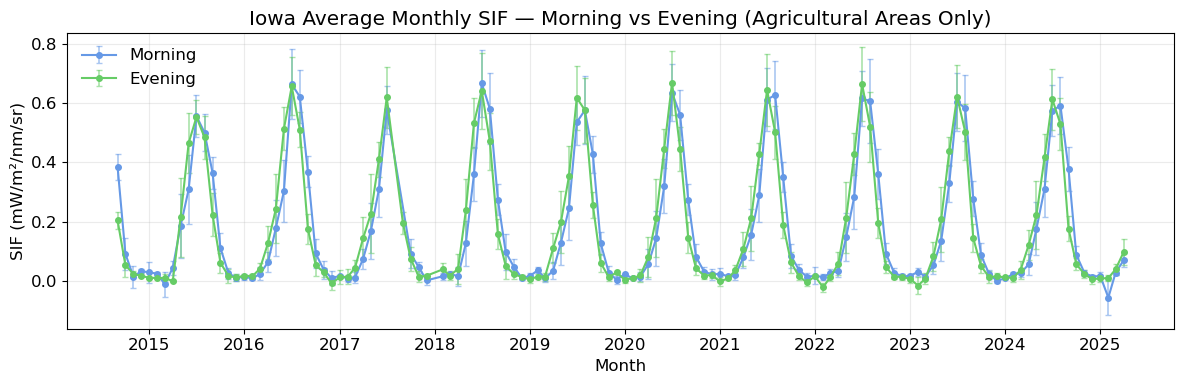

In [21]:
# ---- Plot monthly SIF with error bars (SD) for morning (a) and evening (b) ----

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Keep only the columns we need, sort by time, and ensure types
plot_df = (
    df[["date", "ab", "sif_mean", "sif_sd"]]
      .dropna(subset=["date", "ab", "sif_mean"])        # drop any accidental empties
      .sort_values(["date", "ab"])
      .copy()
)
plot_df["date"] = pd.to_datetime(plot_df["date"])

# Split into morning ('a') and evening ('b') series
am = plot_df[plot_df["ab"] == "a"].copy()
pm = plot_df[plot_df["ab"] == "b"].copy()

# Create the figure and set up nice date formatting on the x-axis
fig, ax = plt.subplots(figsize=(12, 4))

# One major tick per calendar year, label as YYYY
ax.xaxis.set_major_locator(mdates.YearLocator(1))       # tick every 1 year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # show 2014, 2015, ...
marker_style = dict(marker="o", ms=4, mfc="white", mec="none")  # same marker for both series
err_style_a  = dict(elinewidth=1.2, ecolor=(0, 0.2, 0.8, 0.35), capsize=2)  # AM error bars, translucent
err_style_b  = dict(elinewidth=1.2, ecolor=(0.8, 0.2, 0, 0.35), capsize=2)  # PM error bars, translucent

# Darker, still soft and matched
am_color = (0.4, 0.6, 0.9)  
pm_color = (0.4, 0.8, 0.4) 


# AM: solid markers + faded error bars
ax.errorbar(
    am["date"], am["sif_mean"], yerr=am["sif_sd"],
    fmt="-o",                    # line + circle markers
    color=am_color,              # line & marker edge color
    mfc=am_color,                # <-- solid marker face color (fixes white markers)
    mec=am_color,                # marker edge same as line
    ms=4,                        # marker size
    elinewidth=1.2,
    ecolor=(am_color[0], am_color[1], am_color[2], 0.55),  # translucent error bars
    capsize=2,
    linewidth=1.5,
    label="Morning",
    zorder=3
)

# PM: solid markers + faded error bars
ax.errorbar(
    pm["date"], pm["sif_mean"], yerr=pm["sif_sd"],
    fmt="-o",
    color=pm_color,
    mfc=pm_color,                # <-- solid marker face color
    mec=pm_color,
    ms=4,
    elinewidth=1.2,
    ecolor=(pm_color[0], pm_color[1], pm_color[2], 0.55),
    capsize=2,
    linewidth=1.5,
    label="Evening",
    zorder=3
)

# Labels, legend, grid, and tight layout
ax.set_title("Iowa Average Monthly SIF — Morning vs Evening (Agricultural Areas Only)")
ax.set_xlabel("Month")
ax.set_ylabel("SIF (mW/m²/nm/sr)")
ax.legend(loc="best", frameon=False)
ax.grid(alpha=0.25)
fig.tight_layout()

# Save to file
fig.savefig("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_ab_mean_sd.png", dpi=200)

plt.show()


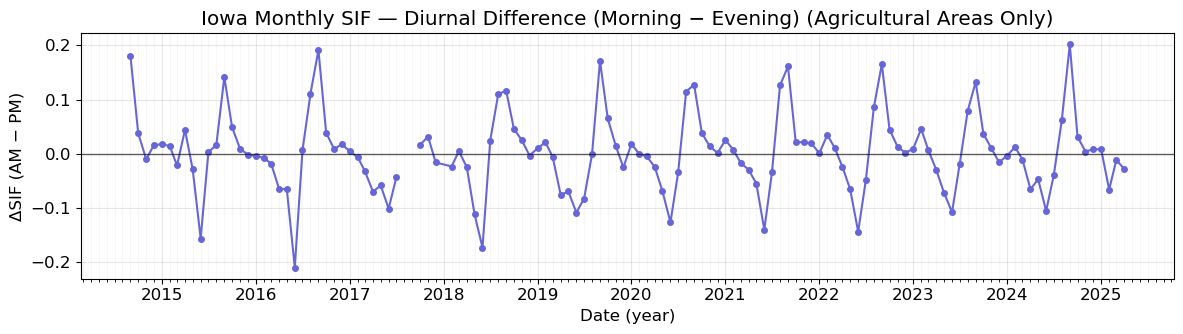

In [22]:
# ---- Diurnal difference plot: (Morning SIF) - (Evening SIF) ----

# Pivot to get columns 'a' and 'b' side-by-side, then compute delta
wide = (
    df[["date", "ab", "sif_mean"]]
      .dropna()
      .pivot(index="date", columns="ab", values="sif_mean")
      .rename(columns={"a": "sif_a", "b": "sif_b"})
      .sort_index()
)
wide["delta_a_minus_b"] = wide["sif_a"] - wide["sif_b"]

# Make the figure
fig, ax = plt.subplots(figsize=(12, 3.5))

# Line + solid markers
ax.plot(wide.index, wide["delta_a_minus_b"], "-o", linewidth=1.5, ms=4, color=(0.40, 0.40, 0.85))

# Zero reference line
ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)

# Year ticks on x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))             # one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))      # label as YYYY
ax.xaxis.set_minor_locator(mdates.MonthLocator())             # (optional) light monthly ticks

# Labels & cosmetics
ax.set_title("Iowa Monthly SIF — Diurnal Difference (Morning − Evening) (Agricultural Areas Only)")
ax.set_xlabel("Date (year)")
ax.set_ylabel("ΔSIF (AM − PM)")
ax.grid(which="major", alpha=0.3)
ax.grid(which="minor", alpha=0.1)
fig.tight_layout()
plt.show()

# Save to file
fig.savefig("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_ab_delta.png", dpi=200)


## 5. Seasonal Averages Across All Years

i. Calculate averages

In [17]:
# Step 1: Calculate monthly averages across all years
print("=" * 60)
print("STEP 1: CALCULATING MONTHLY AVERAGES")
print("=" * 60)

# Calculate average SIF for each month across all years
# We'll create three different averages:

print("1. Morning (AM) averages by month:")
morning_data = df[df['ab'] == 'a']  # Filter for morning data
morning_monthly = morning_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(morning_monthly)
print()

print("2. Evening (PM) averages by month:")
evening_data = df[df['ab'] == 'b']  # Filter for evening data
evening_monthly = evening_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(evening_monthly)
print()

print("3. Combined (AM + PM) averages by month:")
# For combined, we'll average the morning and evening values for each month
combined_monthly = df.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(combined_monthly)
print()

print("Summary:")
print(f"- Morning data: {len(morning_data)} records")
print(f"- Evening data: {len(evening_data)} records") 
print(f"- Total data: {len(df)} records")
print(f"- Months covered: {sorted(df['month'].unique())}")
print()

print("✓ Monthly averages calculated successfully!")
print("Next step: We'll create the seasonal cycle plot with these three lines.")


STEP 1: CALCULATING MONTHLY AVERAGES
1. Morning (AM) averages by month:
           mean       std  count
month                           
1      0.018672  0.005624     10
2      0.012214  0.024329     11
3      0.017260  0.011301     11
4      0.053346  0.019127     11
5      0.155117  0.021321     10
6      0.306143  0.030036     10
7      0.603479  0.043692     10
8      0.582825  0.037755      9
9      0.346168  0.052920     10
10     0.095310  0.013058     11
11     0.032070  0.010012     11
12     0.012942  0.009355     11

2. Evening (PM) averages by month:
           mean       std  count
month                           
1      0.009732  0.005815     10
2      0.009130  0.015913     11
3      0.025969  0.013915     11
4      0.088822  0.042178     11
5      0.219105  0.014026     10
6      0.443135  0.051228     10
7      0.629701  0.033741     10
8      0.504350  0.037111      9
9      0.187798  0.033005     11
10     0.056226  0.008844     11
11     0.018966  0.005347     11
1

ii. Plot the seasonal cycle

STEP 2: CREATING SEASONAL CYCLE PLOT
Preparing data for plotting...
Months with data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Morning means: [0.01867171 0.01221377 0.01725964 0.05334574 0.15511666 0.30614337
 0.60347943 0.58282543 0.34616773 0.09530992 0.03207006 0.01294195]
Evening means: [0.00973217 0.00913044 0.02596911 0.08882201 0.21910455 0.44313548
 0.62970108 0.50435034 0.18779824 0.056226   0.01896649 0.01246406]
Combined means: [0.01420194 0.0106721  0.02161437 0.07108387 0.1871106  0.37463943
 0.61659025 0.54358789 0.26321229 0.07576796 0.02551828 0.012703  ]

Creating the plot with your requested changes...
✓ Plot saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png


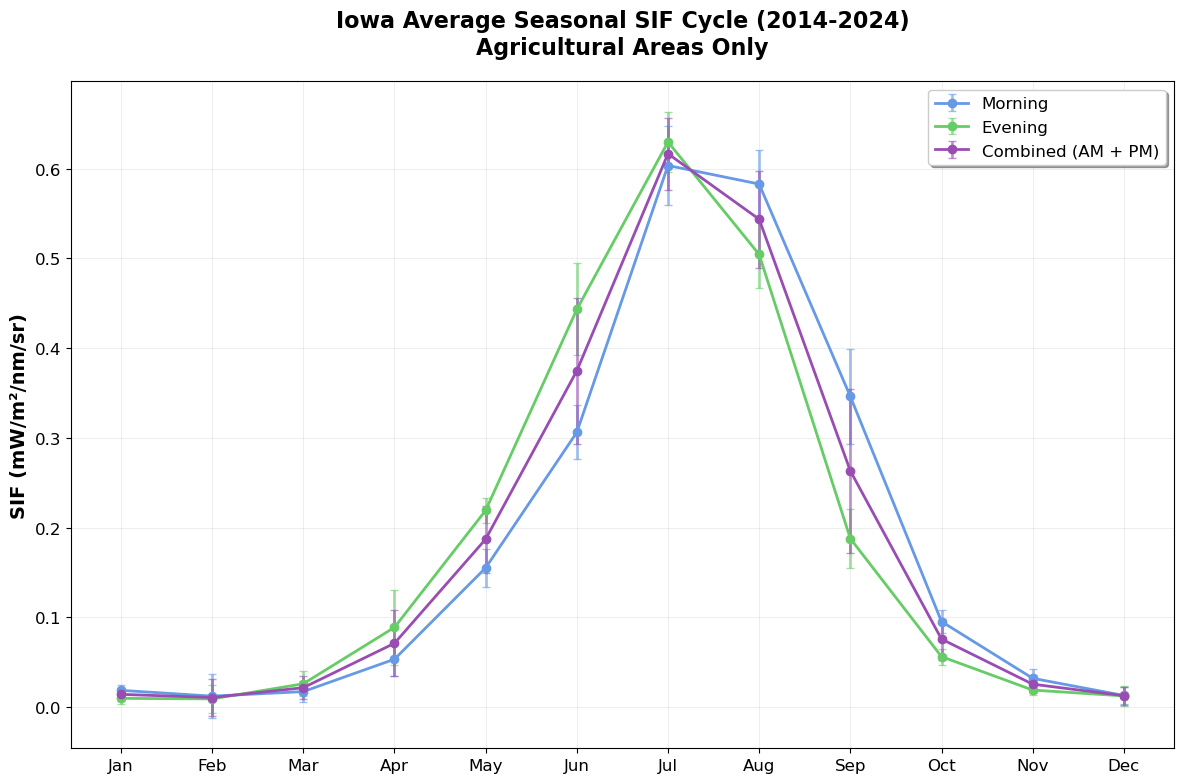

✓ Seasonal cycle plot complete!
This shows the typical seasonal pattern of SIF in Iowa agricultural areas.
Changes made:
- All markers are circles (same shape)
- Error bars are 60% opacity (semi-transparent)
- Proper titles and axis labels added


In [18]:
# Step 2: Create the seasonal cycle plot
print("=" * 60)
print("STEP 2: CREATING SEASONAL CYCLE PLOT")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np

# Step 2a: Prepare the data for plotting
print("Preparing data for plotting...")

# Create month names for better x-axis labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Get the month numbers that we have data for
months_with_data = sorted(morning_monthly.index)
print(f"Months with data: {months_with_data}")

# Extract the mean values for each line
morning_means = morning_monthly['mean'].values
evening_means = evening_monthly['mean'].values
combined_means = combined_monthly['mean'].values

# Extract standard deviations for error bars
morning_stds = morning_monthly['std'].values
evening_stds = evening_monthly['std'].values
combined_stds = combined_monthly['std'].values

print(f"Morning means: {morning_means}")
print(f"Evening means: {evening_means}")
print(f"Combined means: {combined_means}")
print()

# Step 2b: Create the plot with your requested changes
print("Creating the plot with your requested changes...")

# Define colors (using your existing color scheme)
am_color = (0.4, 0.6, 0.9)  # Medium light blue
pm_color = (0.4, 0.8, 0.4)  # Medium light green
combined_color = (0.6, 0.3, 0.7)  # Purple for combined

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three lines with error bars using your colors
# All lines use circles for markers since colors are different
# Morning line (blue)
ax.errorbar(months_with_data, morning_means, yerr=morning_stds,
            fmt='-o', color=am_color, linewidth=2, markersize=6,
            label='Morning', capsize=3, capthick=1, 
            mfc=am_color, mec=am_color,  # Solid markers
            ecolor=(am_color[0], am_color[1], am_color[2], 0.6))  # Semi-transparent error bars only

# Evening line (green) 
ax.errorbar(months_with_data, evening_means, yerr=evening_stds,
            fmt='-o', color=pm_color, linewidth=2, markersize=6,
            label='Evening', capsize=3, capthick=1, 
            mfc=pm_color, mec=pm_color,  # Solid markers
            ecolor=(pm_color[0], pm_color[1], pm_color[2], 0.6))  # Semi-transparent error bars only

# Combined line (purple)
ax.errorbar(months_with_data, combined_means, yerr=combined_stds,
            fmt='-o', color=combined_color, linewidth=2, markersize=6,
            label='Combined (AM + PM)', capsize=3, capthick=1, 
            mfc=combined_color, mec=combined_color,  # Solid markers
            ecolor=(combined_color[0], combined_color[1], combined_color[2], 0.6))  # Semi-transparent error bars only

# Add proper labels and formatting
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_ylabel('SIF (mW/m²/nm/sr)', fontsize=14, fontweight='bold')
ax.set_title('Iowa Average Seasonal SIF Cycle (2014-2024)\nAgricultural Areas Only', 
             fontsize=16, fontweight='bold', pad=20)

# Set x-axis to show month names
ax.set_xticks(months_with_data)
ax.set_xticklabels([month_names[m-1] for m in months_with_data], fontsize=12)

# Add legend and grid
ax.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Make it look nice
plt.tight_layout()

# Save the figure
output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png"
fig.savefig(output_path, dpi=200, bbox_inches='tight')
print(f"✓ Plot saved to: {output_path}")

# Show the plot
plt.show()

print("✓ Seasonal cycle plot complete!")
print("This shows the typical seasonal pattern of SIF in Iowa agricultural areas.")
print("Changes made:")
print("- All markers are circles (same shape)")
print("- Error bars are 60% opacity (semi-transparent)")
print("- Proper titles and axis labels added")


iii. Plot the difference between AM and PM

STEP 3: CREATING AM - PM DIFFERENCE PLOT

Morning - Evening SIF Difference by Month:
month
1     0.008940
2     0.003083
3    -0.008709
4    -0.035476
5    -0.063988
6    -0.136992
7    -0.026222
8     0.078475
9     0.158369
10    0.039084
11    0.013104
12    0.000478
Name: mean, dtype: float64

✓ Plot saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_am_pm_difference.png


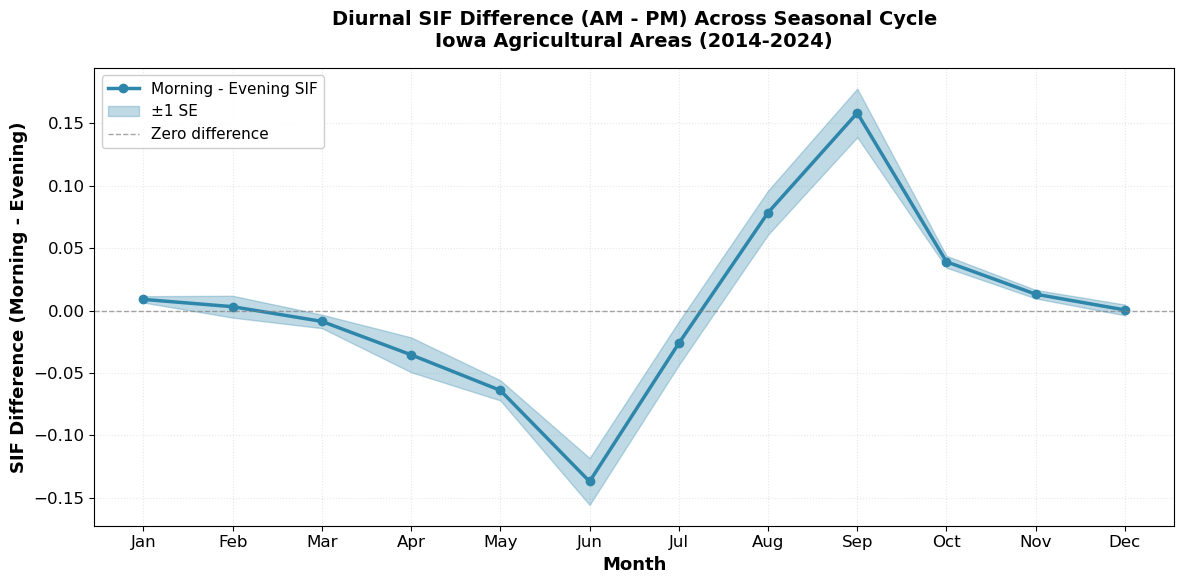


SUMMARY STATISTICS:
Mean difference (AM - PM): 0.0025
Max difference: 0.1584 (Month 9)
Min difference: -0.1370 (Month 6)

Interpretation:
  - Positive values: Morning SIF is higher than evening SIF
✓ AM - PM difference plot complete!


In [23]:
# Step 3: Plot the difference between morning and evening SIF
print("=" * 60)
print("STEP 3: CREATING AM - PM DIFFERENCE PLOT")
print("=" * 60)

# Calculate the difference (Morning - Evening) for each month
am_pm_diff = morning_monthly['mean'] - evening_monthly['mean']

# Calculate combined standard error for the difference
# Using error propagation: SE_diff = sqrt(SE_am^2 + SE_pm^2)
# SE = std / sqrt(count)
morning_se = morning_monthly['std'] / np.sqrt(morning_monthly['count'])
evening_se = evening_monthly['std'] / np.sqrt(evening_monthly['count'])
diff_se = np.sqrt(morning_se**2 + evening_se**2)

print("\nMorning - Evening SIF Difference by Month:")
print(am_pm_diff)
print()

# Create month labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = am_pm_diff.index.values

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the difference with error bars
ax.plot(months, am_pm_diff.values, 
        color='#2E86AB', linewidth=2.5, marker='o', markersize=6,
        label='Morning - Evening SIF')

# Add error bars (shaded region)
ax.fill_between(months, 
                am_pm_diff.values - diff_se.values,
                am_pm_diff.values + diff_se.values,
                alpha=0.3, color='#2E86AB', label='±1 SE')

# Add a horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Zero difference')

# Styling
ax.set_xlabel('Month', fontsize=13, fontweight='bold')
ax.set_ylabel('SIF Difference (Morning - Evening)', fontsize=13, fontweight='bold')
ax.set_title('Diurnal SIF Difference (AM - PM) Across Seasonal Cycle\nIowa Agricultural Areas (2014-2024)', 
             fontsize=14, fontweight='bold', pad=15)

# Set x-axis to show month names
ax.set_xticks(months)
ax.set_xticklabels([month_names[m-1] for m in months])

# Add grid
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_axisbelow(True)

# Add legend
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

# Tight layout
plt.tight_layout()

# Save the figure
output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_am_pm_difference.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Plot saved to: {output_path}")

plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS:")
print("=" * 60)
print(f"Mean difference (AM - PM): {am_pm_diff.mean():.4f}")
print(f"Max difference: {am_pm_diff.max():.4f} (Month {am_pm_diff.idxmax()})")
print(f"Min difference: {am_pm_diff.min():.4f} (Month {am_pm_diff.idxmin()})")
print()
print("Interpretation:")
if am_pm_diff.mean() > 0:
    print("  - Positive values: Morning SIF is higher than evening SIF")
else:
    print("  - Negative values: Evening SIF is higher than morning SIF")
print("=" * 60)
print("✓ AM - PM difference plot complete!")


8. Anomalies

## 7. Maps!

i. Difference in AM and PM in July

ii. Drought year and non drought year